# Customer Churn Prediction with IBM Db2 using PySpark

# Part 1 : Data exploration

__Introduction__

This notebook presents a churn prediction use case using anonymized customer data from a phone operator. It uses IBM Db2 Warehouse and runs on a PySpark kernel. It is the first part of a series on this use case. It is focused on data exploration and visualization. The goal is to gain some insights for feature selection. Visualizations are plotted locally using seaborn and matplotlib whereas data is manipulated with PySpark and is loaded from IBM Db2.

__Use case__

Our goal is to accurately predict whether a customer is going to end his/her contract (labeled as positive,1). We prefer to send a commercial email to someone who intends to keep her contract but is labeled as willing to end it (false positive) rather than to overlook the opportunity of preventing a customer from ending her contract (false negative). We also care to accurately target customers with engagement campaigns : not overwhelming customers with commercials and not losing money by proposing special offers to too many people (accuracy). Our optimization objective will thus consist in maximizing recall id est minimizing the false negative rate. We will also look at a couple of other indicators such as accuracy and area under curve.

__Contents__
1. Get ready
2. Explore the data
3. Prepare the data

## 1. Get ready

__Imports__

Import the necessary Spark classes, as well as Python packages for local visualisations.
We will plot the graphs directly in this notebook. If you like to plot them in a separate window, just comment out `%matplotlib inline`.

In [1]:
# Useful imports - PySpark

from pyspark.sql import SparkSession

from pyspark.ml.linalg import Vectors

from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.feature import MinMaxScaler

import numpy as np

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
160,None,pyspark,idle,,,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
%local
%matplotlib inline

# Useful imports for local visualisations

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import polyfit

__Load the data__

Let's use a table which has been pre-populated in Db2 local. It is called SAMPLES.TRAINING. 

In [3]:
sparkSession = SparkSession \
        .builder \
        .getOrCreate()

df = sparkSession.read \
        .format("com.ibm.idax.spark.idaxsource") \
        .options(dbtable="SAMPLES.TRAINING") \
        .load()
df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|CHURN|AREA|VMAIL|VMAIL_MSGS|DAY_MINS|DAY_CALLS|DAY_CHARGE|EVE_MINS|EVE_CALLS|EVE_CHARGE|NIGHT_MINS|NIGHT_CALLS|NIGHT_CHARGE|INTL_MINS|INTL_CALLS|INTL_CHARGE|SVC_CALLS|
+-----+----+-----+----------+--------+---------+----------+--------+---------+----------+----------+-----------+------------+---------+----------+-----------+---------+
|    0| 415|    1|         0|   147.7|       94|     25.11|   283.3|       83|     24.08|     188.3|        124|        8.47|      6.9|         5|       1.86|        2|
|    0| 408|    1|         0|   229.9|      130|     39.08|   144.4|       93|     12.27|     262.4|        110|       11.81|     14.2|         4|       3.83|        2|
|    0| 408|    1|         0|   102.8|      128|     17.48|   143.7|       95|     12.21|     191.4|         97|        8.61|     10.0|         5|       2.

Quick look-up : How many records do we have? How many features?

In [4]:
print('Number of records: '+str(df.count()))
print('Number of features: '+str(len(df.columns)))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of records: 3333
Number of features: 17

__Split the data__

We split the data into three distinct sets: for training, validation and testing. We use the proportions 70%, 15% and 15% so that we keep a relatively high number of examples for training. Of course these proportions are subjective, you can change them if you want. We have defined a seed so that results can be reproduced : the same splits are made in the other notebook.

In [5]:
train, val, test = df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 2. Explore the data

Of course we only explore the training data because we are not allowed to look at validation and test data during the training phase.

__Data schema__

In [6]:
train.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)

Columns include:

- Churn : whether the customer resigned his/her phone subscription, this is our target
- Area : a geographic label, we might wonder which impact this feature has on churn
- VMail: whether voice messages have been left (1 means no message)
- VMail_msgs: number of voice messages
- day_mins, eve_mins, night_mins, intl_mins: time spend calling in the day/evening/night/abroad
- day_calls, eve_calls, night_calls, intl_calls: number of calls in each category
- day_charge, eve_charge, night_charge, intl_charge: price charged for each category
- svc_calls: service calls.

__A few statistics__

In [7]:
train.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                  0                    1                   2     3      4
summary       count                 mean              stddev   min    max
CHURN          2321  0.14174924601464886  0.3488679339968042     0      1
AREA           2321   437.55751831107284   42.59040370355355   408    510
VMAIL          2321   0.7152089616544592  0.4514121156178144     0      1
VMAIL_MSGS     2321    8.279190004308488  13.739715352375883     0     51
DAY_MINS       2321            179.33903  53.492828972507816   0.0  346.8
DAY_CALLS      2321   100.40284360189574  19.978203006244552     0    163
DAY_CHARGE     2321            30.488221   9.093726341385404  0.00  58.96
EVE_MINS       2321            201.51848   50.21325512364999   0.0  354.2
EVE_CALLS      2321     99.6574752261956    19.8937554403215     0    170
EVE_CHARGE     2321            17.129324   4.268134567793463  0.00  30.11
NIGHT_MINS     2321            199.86614   50.34348234633579  23.2  395.0
NIGHT_CALLS    2321    99.949590693666

We see that there is no missing value in the dataset, which is great: no cleaning needed so far. 

We have a turnout of roughly 15%, so __we must do better than a 85% accuracy__. 85% would be the accuracy of a naive classifier which labels all examples as 0 id est customer remains a client.

__Visualization__

Let's answer the following questions thanks to visualizations: What relationships do exist between features? How are features correlated to churn? What is the average price per minute? Are there outliers? How does feature distributions look like?

* Pull data locally for visualization

Note: our dataset is small so local visualization may be performed without sampling. In practice, with big data sets, you can take a random sample of data for visualization.

First we create a temporary view of our Spark dataframe. Then we query it in an %%sql cell. Finally it is available locally as a Pandas dataframe and can be plotted conveniently. 

In [8]:
train.createOrReplaceTempView('train')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
%%sql -o train --maxrows -1
SELECT * FROM train

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/autovizwidget/widget/utils.py:50: FutureWarning:

A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.



Output()

__Explore relationships between features with a scatter plot__


Note: Color code is blue if CHURN is 0, red if CHURN is 1. This can take some time. To zoom in, double-click on the image.

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning:

invalid value encountered in true_divide

/Users/eva.feillet/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning:

invalid value encountered in double_scalars



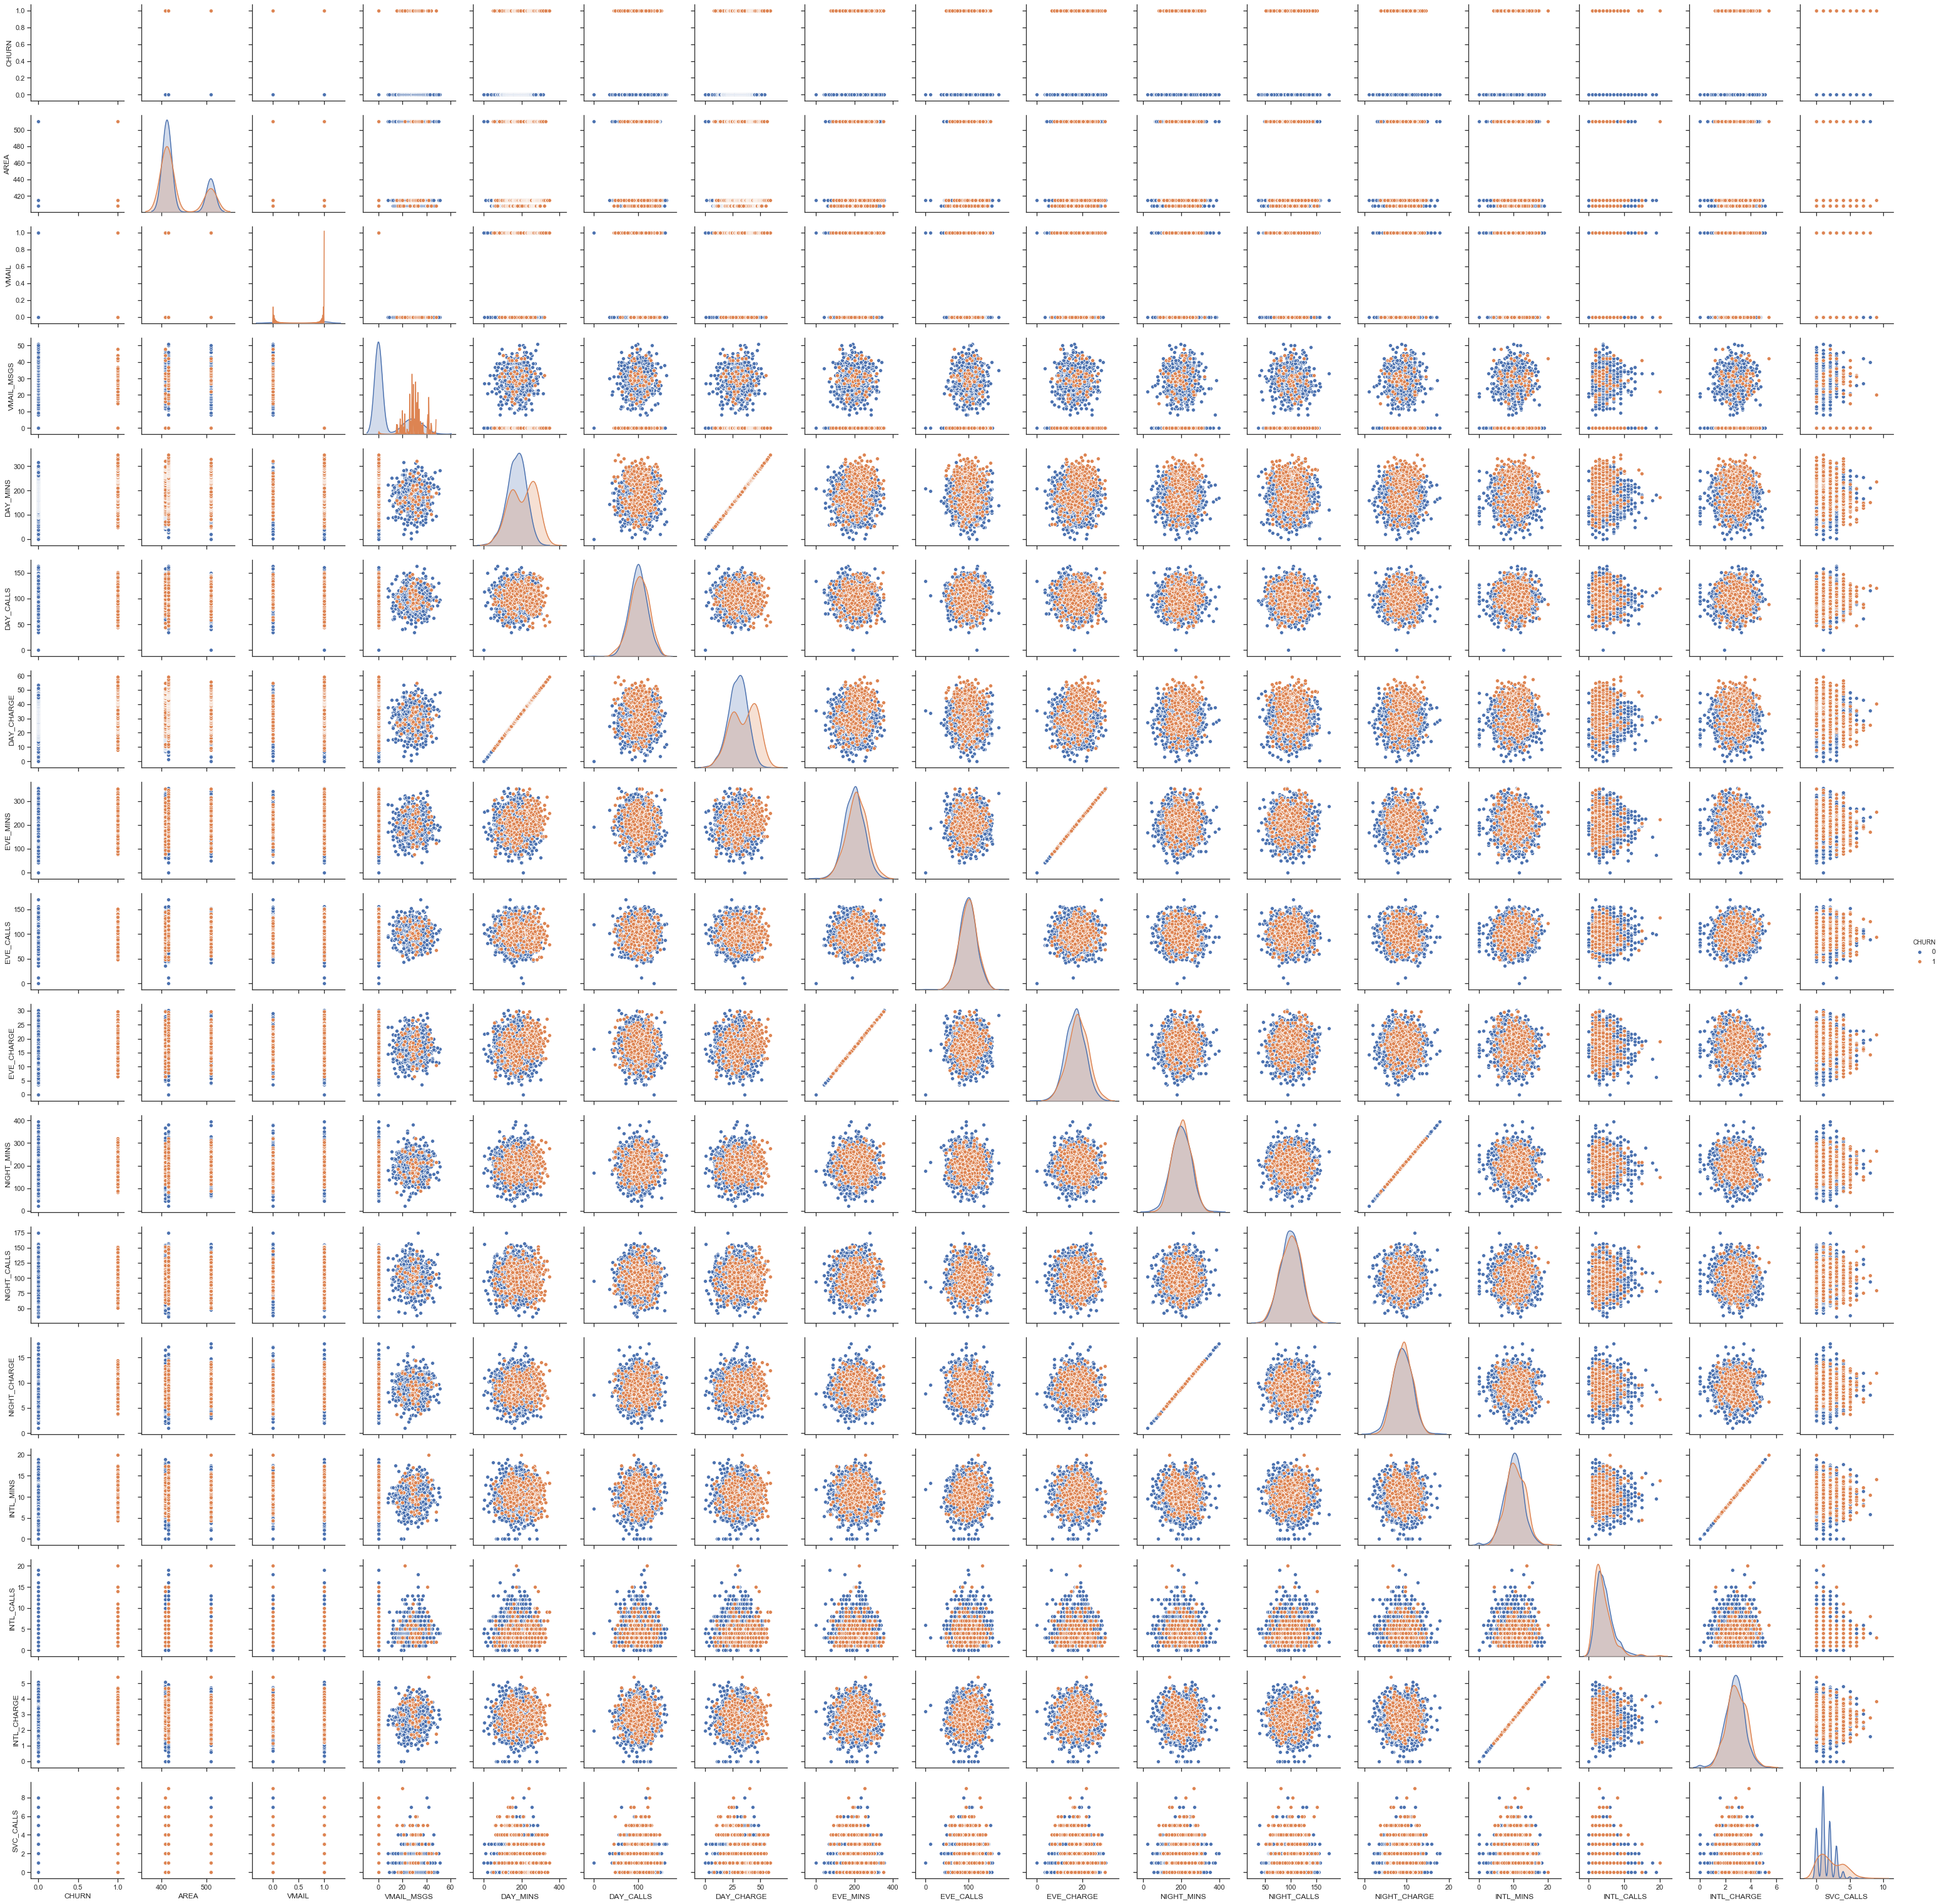

In [10]:
%local

sns.set(style="ticks")

sns.pairplot(train, hue='CHURN')


Comments
- most people who have no voice mail messages are likely to end their contract;
- churners with voice mail messages or particularly if they receive between 20 and 40 voice messages;
- distribution of number of calls and cumulated time among each category is very similar between classes churn=1 and churn=0. This might make our prediction task hard to perform;
- service calls distributions however differ from class 0 to class 1. They also all come from the same area;
- concentric round patterns tend to appear but the red zone is superimposed with the blue underlying zone, so this might also make prediction hard;
- pricing seems to be linear (simple linear function between time and price, no flat rate or minimum charge).

__Find out the price per minute with a linear regression__

In the previous section we could see that a linear function seems to map the time spent on the phone to the price actually charged. To confirm this intuition, let's perform a linear regression in order to compute the average price per minute. We take the example of phone calls made during day time, the same method can be applied to the other categories. But first, let's compare prices between categories.

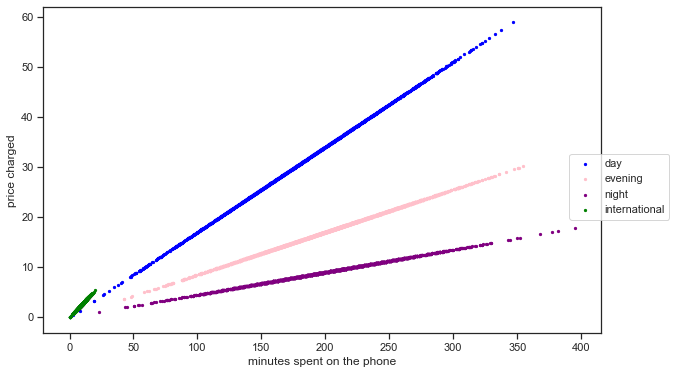

In [11]:
%local

# Price charged per minute - category comparison

ax, fig=plt.subplots(figsize=(10,6))

plt.scatter(train['DAY_MINS'], train['DAY_CHARGE'], color='blue', s=5, label='day')
plt.scatter(train['EVE_MINS'], train['EVE_CHARGE'], color='pink', s=5, label='evening')
plt.scatter(train['NIGHT_MINS'], train['NIGHT_CHARGE'], color='purple', s=5, label='night')
plt.scatter(train['INTL_MINS'], train['INTL_CHARGE'], color='green', s=5, label='international')


plt.xlabel('minutes spent on the phone')
plt.ylabel('price charged')

ax.legend(loc='right')

plt.show()

International calls are more expensive. A higher price is charged during the day than during the evening and the night. It seems that for each call type, a linear pricing is applied. Let's confirm this intuition by building a linear regression model and computing the error on separate data.

First, be have to prepare the data so that it is in the format [feature, label] required by the dedicated PySpark functions.

In [12]:
# Data preparation

#Select necessary features DAY_MINS (input feature) and DAY_CHARGE (target feature or label)
data_DAY = train.select(train.DAY_MINS, train.DAY_CHARGE)
# Check the schema
#print('Schema of data_DAY')
#data_DAY.printSchema()

# Split data in a training and a testing set in order to assess the quality of our regression
train_DAY, test_DAY = data_DAY.randomSplit([0.7,0.3])

# Define the vector assembler you need for this linear regression
DAY_assembler = VectorAssembler().setInputCols(['DAY_MINS',]).setOutputCol('features')

# Transform the datasets according to this assembler
train01 = DAY_assembler.transform(train_DAY)
test01 = DAY_assembler.transform(test)
# Check the schema: a new column has been created
#print("Schema of train01")
#train01.printSchema()

# Rename the DAY_CHARGE column to label and select omly the label and features column
train02 = train01.select(train01["features"], train01["DAY_CHARGE"].alias("label"))
test02 = test01.select(test01["features"], test01["DAY_CHARGE"].alias("label"))
# Check how your data looks like
print("Data lookup: train02")
train02.show(5, truncate=False)

# we need to have the keywords features, label and prediction as column names

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Data lookup: train02
+--------+-----+
|features|label|
+--------+-----+
|[0.0]   |0.00 |
|[2.6]   |0.44 |
|[7.8]   |1.33 |
|[18.9]  |3.21 |
|[25.9]  |4.40 |
+--------+-----+
only showing top 5 rows

Define the model characteristics and fit the model to your training set.

In [13]:
lr = LinearRegression(featuresCol="features", labelCol="label",maxIter=10, regParam=0.3, elasticNetParam=0.8)
LRmodel = lr.fit(train02)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Compute training error: Regression coefficient R2 and RMSE

In [14]:
train03 = LRmodel.transform(train02)
train04 = train03.select(train03["features"], train03["label"], train03["prediction"])

evaluator = RegressionEvaluator()
print("R^2: %f" % evaluator.evaluate(train04,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(train04,{evaluator.metricName: "rmse"}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R^2: 0.998935
RMSE: 0.298055

Make prediction on test set and compute the test error 

In [15]:
test03 = LRmodel.transform(test02)
test04 = test03.select(test03["features"], test03["label"], test03["prediction"])
#test04.show(5, truncate=False)

evaluator = RegressionEvaluator()
print("R^2: %f" % evaluator.evaluate(test04,{evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(test04,{evaluator.metricName: "rmse"}))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

R^2: 0.998934
RMSE: 0.318656

R is the regression coefficient. R² value ~ 1 is a good fit. 
The Root Mean Square Error (RMSE) has to be compared to the actual magnitude of the phenomenon. In our case, it is low compared to the mean DAY_CHARGE value (30.56) and its standard deviation (9.24).

This confirm the impression we got from visualization. From now on we can assume that a linear function maps day_mins to day_charge. It's the same for the other categories. We shall then use only the "charge" columns in the next steps of our analysis.

Price per minute

In [16]:
# Print the coefficients for linear regression
print("Price per minute in the day: %.3f " % LRmodel.coefficients[0])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Price per minute in the day: 0.164

Finally, we can plot the curve with the points.

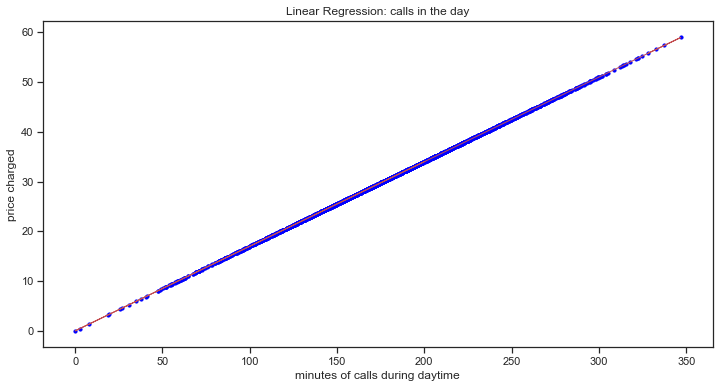

In [17]:
%local

plt.figure(figsize=(12,6))

x1 = train['DAY_MINS'].astype('float').values.tolist()
y1 = train['DAY_CHARGE'].astype('float').values.tolist()

p1 = polyfit(x1, y1, 1)
plt.plot(x1, np.polyval(p1,x1), 'r-', linewidth=1)


plt.scatter(x1, y1, color='blue', s=10)

plt.xlabel('minutes of calls during daytime')
plt.ylabel('price charged')
plt.title('Linear Regression: calls in the day')

plt.show()

__Customer churn and phoning habits__

Let's see if we can spot some patterns in the data with a scatter plot showing the total number of minutes spent on the phone.

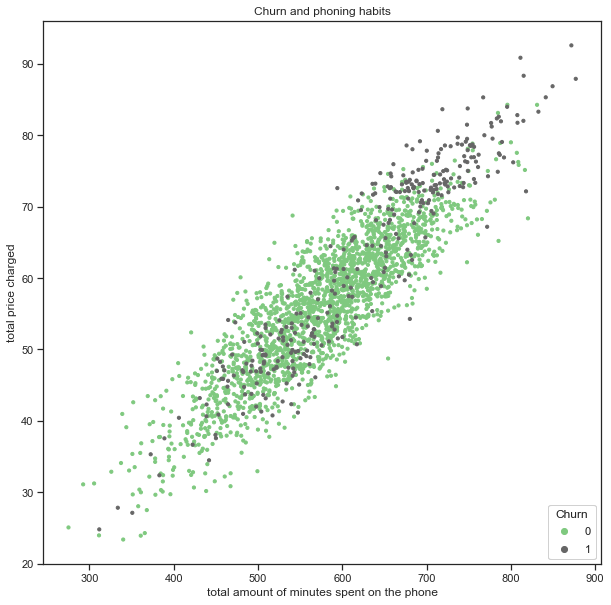

In [18]:
%local

#total amount of time spent on the phone
tot_mins=train['DAY_MINS']+train['EVE_MINS']+train['NIGHT_MINS']

#total price charged
tot_charge=train['DAY_CHARGE']+train['EVE_CHARGE']+train['NIGHT_CHARGE']


# Plot

x, y = tot_mins, tot_charge
c = train['CHURN']

fig, ax = plt.subplots(figsize=(10,10))

scatter = ax.scatter(x, y, c=c, s=10, cmap='Accent')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Churn")
ax.add_artist(legend1)

plt.xlabel('total amount of minutes spent on the phone')
plt.ylabel('total price charged')

plt.title('Churn and phoning habits')
plt.savefig('churn')
plt.show()

There seem to be a cluster of people who ended their contract and used the service more than others. People who resigned their contract tend to be charged more than others because they have a high consumption, or to have a middle/low range consumption... which does not allow us to tell them apart from the others for now. There could be two customer clusters as drawn here:

<img src="churn_clusters.png"/>

__Correlation matrix__

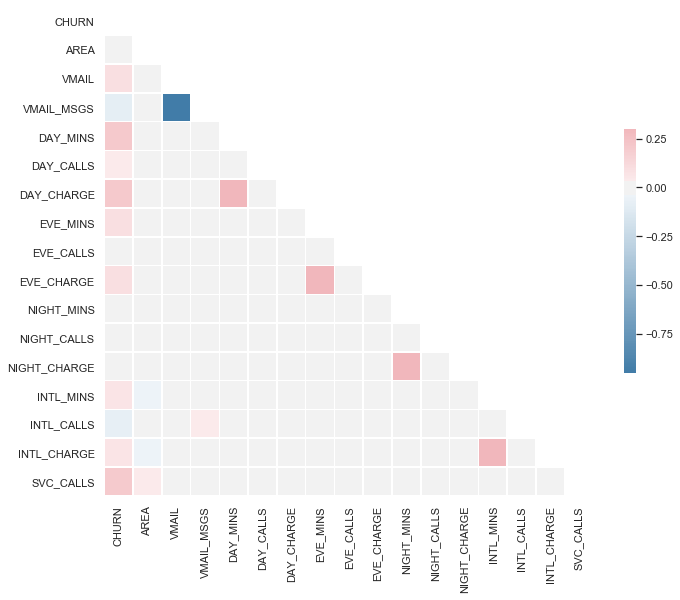

In [19]:
%local

sns.set(style="white")

# Compute the correlation matrix
corr = train.corr()

# Generate a mask for the upper triangle
# Since the matrix is symmetric, we just need one half of the coefficients
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


Features tend not to be very correlated! 

A positive correlation between two features means that the two phenomenons tend to grow together.

Here are the factors that seem to encourage a customer to end his/her contract:

Particularly:
* time spent on the phone in the day
* service calls

And then:
* time spent on international calls
* having no voice mail message

Factors that encourage a customer not to end a contract:
* number of voice mail messages received
* number of international calls made.

Additionaly, we can again observe the linear relation we had alreay discovered between time spent on the phone and price charged. It appears here on the correlation matrix for each type of call. We will therefore delete redundant columns in the next steps of this notebook.

## 3. Prepare the data

__Create new columns__

Here we create a new column. Feel free to come up with new feature combinations and transformations.

In [20]:
# 4 new features
TOT_MINS = df['DAY_MINS']+df['EVE_MINS']+df['INTL_MINS']+df['NIGHT_MINS']
DAY_MINS_perCALL = df['DAY_MINS']/df['DAY_CALLS']
NIGHT_MINS_perCALL = df['NIGHT_MINS']/df['NIGHT_CALLS']
EVE_MINS_perCALL = df['EVE_MINS']/df['EVE_CALLS']
# type <class 'pyspark.sql.column.Column'>

# Add the columns to the existing ones in a new dataframe
tot_df = df.withColumn("TOT_MINS", TOT_MINS).withColumn("DAY_MINS_perCALL", DAY_MINS_perCALL).withColumn("NIGHT_MINS_perCALL", NIGHT_MINS_perCALL).withColumn("EVE_MINS_perCALL", EVE_MINS_perCALL)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
tot_df.describe().toPandas().transpose()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

                        0                    1  ...               3                4
summary             count                 mean  ...             min              max
CHURN                3333  0.14491449144914492  ...               0                1
AREA                 3333   437.18241824182417  ...             408              510
VMAIL                3333   0.7233723372337234  ...               0                1
VMAIL_MSGS           3333    8.099009900990099  ...               0               51
DAY_MINS             3333            179.77510  ...             0.0            350.8
DAY_CALLS            3333   100.43564356435644  ...               0              165
DAY_CHARGE           3333            30.562307  ...            0.00            59.64
EVE_MINS             3333            200.98035  ...             0.0            363.7
EVE_CALLS            3333   100.11431143114311  ...               0              170
EVE_CHARGE           3333            17.083540  ...            0.

Here we notice that there are a few missing values in the new columns, due to divisions by zero. Let's drop these rows in our dataframe.

In [22]:
# Sets with the new columns
train0, val0, test0 = tot_df.randomSplit([0.70,0.15,0.15],1)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# Drop the rows with None values
train, val, test = train0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"]), val0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"]), test0.dropna(subset = ["DAY_MINS_perCALL", "EVE_MINS_perCALL"])

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now we assemble columns into a "features" list because this is  the format required by most PySpark ML functions we will use in the following steps.

In [24]:
assembler = VectorAssembler(
    inputCols=["TOT_MINS", "DAY_MINS_perCALL", "EVE_MINS_perCALL", "NIGHT_MINS_perCALL", "VMAIL_MSGS", "VMAIL", "INTL_CALLS", "DAY_CALLS", "EVE_CALLS", "NIGHT_CALLS", "SVC_CALLS", "INTL_CHARGE", "DAY_CHARGE", "EVE_CHARGE", "NIGHT_CHARGE"],
    outputCol="rawFeatures")
assembled_train = assembler.transform(train)
assembled_train.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)
 |-- TOT_MINS: decimal(8,1) (nullable = true)
 |-- DAY_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- NIGHT_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- EVE_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- rawFeature

__Feature scaling__

Let's scale our features with a MinMax transformation. This is useful in so far as we have features on very different scales.

In [25]:
# Feature Scaling
scaler = MinMaxScaler(inputCol = "rawFeatures", outputCol = "features")

scalerModel = scaler.fit(assembled_train)

scaled_train = scalerModel.transform(assembled_train)

scaled_train.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- CHURN: short (nullable = false)
 |-- AREA: integer (nullable = false)
 |-- VMAIL: short (nullable = false)
 |-- VMAIL_MSGS: integer (nullable = false)
 |-- DAY_MINS: decimal(5,1) (nullable = false)
 |-- DAY_CALLS: integer (nullable = false)
 |-- DAY_CHARGE: decimal(5,2) (nullable = false)
 |-- EVE_MINS: decimal(5,1) (nullable = false)
 |-- EVE_CALLS: integer (nullable = false)
 |-- EVE_CHARGE: decimal(5,2) (nullable = false)
 |-- NIGHT_MINS: decimal(5,1) (nullable = false)
 |-- NIGHT_CALLS: integer (nullable = false)
 |-- NIGHT_CHARGE: decimal(5,2) (nullable = false)
 |-- INTL_MINS: decimal(4,1) (nullable = false)
 |-- INTL_CALLS: integer (nullable = false)
 |-- INTL_CHARGE: decimal(4,2) (nullable = false)
 |-- SVC_CALLS: integer (nullable = false)
 |-- TOT_MINS: decimal(8,1) (nullable = true)
 |-- DAY_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- NIGHT_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- EVE_MINS_perCALL: decimal(16,12) (nullable = true)
 |-- rawFeature

__Select features__ 

Not all columns are relevant for our prediction task. Some columns even bring more noise than useful information, so that we better get rid of them. Here we choose to only keep the 12 most relevant features out of the 20 we have. We use the Chi-test method for this.

In [26]:
selector = ChiSqSelector(numTopFeatures=12, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="CHURN")

result = selector.fit(scaled_train).transform(scaled_train)

print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
result.select("selectedFeatures").take(3)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

ChiSqSelector output with top 12 features selected
[Row(selectedFeatures=DenseVector([0.5479, 0.3875, 0.1284, 0.2316, 0.2353, 0.0, 0.25, 0.3203, 0.0, 0.5093, 0.5743, 0.6776])), Row(selectedFeatures=DenseVector([0.4327, 0.272, 0.044, 0.3683, 0.2549, 0.0, 0.2, 0.5391, 0.1111, 0.6056, 0.5535, 0.2225])), Row(selectedFeatures=DenseVector([0.5302, 0.4703, 0.0998, 0.3736, 0.2549, 0.0, 0.15, 0.2344, 0.1111, 0.4852, 0.5955, 0.3541]))]

In the next steps, we will use the 12 following features : SVC_CALLS, DAY_MINS, DAY_CHARGE, VMAIL_MSGS, VMAIL, INTL_CALLS, INTL_CHARGE, INTL_MINS, EVE_CHARGE, EVE_MINS, NIGHT_MINS, NIGHT_CHARGE.

## What you've learned

Congratulations!

Through this notebook, you've seen how to:
* load data from Db2 into a Jupyter notebook
* use PySpark for data exploration and preparation
* manipulate some classic data transformation tools.

You're all set for the next step of our ML use case! Please go to the next notebook of the series : Churn_Prediction_PySpark_models. We will use clustering to enrich our data and will compare the performance of different supervised learning models.


___
## Authors

Eva Feillet - ML intern, IBM Cloud and Cognitive Software, IBM Lab in Böbligen, Germany